In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
import numpy as np

In [ ]:
train_targets = pd.read_csv('train_targets.csv')
X_test_estimated = pd.read_csv('X_test_estimated.csv')
X_train_estimated = pd.read_csv('X_train_estimated.csv')
X_train_observed = pd.read_csv('X_train_observed.csv')

In [61]:
X_train_observed.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,29668,29668.000000,29668.000000,29668.000000,2.966800e+04,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,...,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000
mean,2021-02-09 23:30:00,6.652541,1.249066,3163.556428,5.993853e+05,166.499231,1873.489861,0.022785,276.822981,45.021690,...,182.429217,1.527661,0.059145,280.708561,74.307702,32446.553637,3.042952,0.754783,0.514868,0.000024
min,2019-06-02 22:00:00,0.700000,1.145000,27.800000,0.000000e+00,0.000000,27.900000,-1.000000,250.900000,0.000000,...,0.012000,-49.941000,0.000000,258.900000,0.000000,154.300000,0.000000,-7.300000,-9.300000,-0.000000
25%,2020-04-06 22:45:00,4.400000,1.224000,1109.250000,0.000000e+00,0.000000,596.075000,0.000000,272.100000,0.000000,...,90.750500,-15.149000,0.000000,275.900000,53.700000,14959.125000,1.700000,-1.400000,-0.700000,0.000000
50%,2021-02-09 23:30:00,6.300000,1.247000,1982.850000,3.645785e+04,8.200000,1206.400000,0.000000,277.200000,4.600000,...,179.517500,1.148000,0.000000,280.700000,94.800000,36747.850000,2.700000,0.400000,0.500000,-0.000000
75%,2021-12-16 00:15:00,8.600000,1.272000,4571.225000,1.042457e+06,285.400000,2199.625000,0.000000,282.000000,76.900000,...,273.256500,18.766750,0.100000,285.200000,100.000000,48326.575000,4.100000,2.700000,1.700000,0.000000
max,2022-10-21 01:00:00,17.500000,1.427000,12328.500000,3.004693e+06,834.800000,11688.700000,1.000000,293.800000,336.700000,...,359.996000,49.880000,1.400000,303.300000,100.000000,71349.900000,15.200000,12.200000,8.600000,0.100000
std,NaN,2.798130,0.036344,2822.818778,8.795484e+05,244.944679,2024.261706,0.191028,6.705049,64.627907,...,103.769571,24.148768,0.112496,6.577199,34.186838,18244.411915,1.792310,2.858518,1.862125,0.001536


In [62]:
X_train_estimated.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,4394,4394.000000,4394.000000,4394.000000,4.394000e+03,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,...,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.0
mean,2023-01-28 22:49:20.127446272,4.092581,1.281733,3534.729472,2.371242e+05,65.868730,1695.017137,0.009786,270.222872,22.919413,...,182.532631,-10.693312,0.032453,274.724078,73.725307,33475.082499,3.182863,-0.016545,0.923259,0.0
min,2022-10-28 22:00:00,1.000000,1.212000,27.900000,0.000000e+00,0.000000,27.800000,-1.000000,254.700000,0.000000,...,8.099000,-49.921000,0.000000,259.700000,0.000000,190.500000,0.100000,-7.200000,-5.300000,-0.0
25%,2022-12-13 16:15:00,3.000000,1.262000,1069.550000,0.000000e+00,0.000000,447.400000,0.000000,266.800000,0.000000,...,97.182750,-28.352750,0.000000,271.800000,47.925000,19430.850000,1.700000,-2.200000,-0.200000,0.0
50%,2023-01-29 10:30:00,3.900000,1.279000,2799.550000,0.000000e+00,0.000000,877.950000,0.000000,270.400000,0.000000,...,186.832500,-10.001500,0.000000,274.700000,98.000000,34847.250000,2.900000,-0.300000,1.000000,-0.0
75%,2023-03-16 04:45:00,5.100000,1.301000,5337.725000,1.383404e+05,37.400000,2025.100000,0.000000,273.900000,23.175000,...,267.941750,4.499500,0.000000,277.800000,100.000000,48032.525000,4.300000,1.500000,2.000000,-0.0
max,2023-04-30 23:00:00,8.800000,1.374000,12307.700000,2.551917e+06,710.300000,10813.700000,1.000000,282.100000,296.900000,...,359.710000,41.119000,0.900000,285.900000,100.000000,68498.500000,10.500000,10.100000,6.800000,-0.0
std,NaN,1.512247,0.030087,2960.864924,5.173883e+05,144.175208,2025.268566,0.224079,5.219171,45.826780,...,100.127552,21.692067,0.084507,4.643158,36.318543,17188.421973,1.799562,3.061109,1.774366,0.0


In [63]:
df = pd.concat([X_train_observed, X_train_estimated])
df.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,34062,34062.000000,34062.000000,34062.000000,3.406200e+04,34062.000000,34062.000000,34062.000000,34062.000000,34062.000000,...,34062.000000,34062.000000,34062.000000,34062.000000,34062.000000,34062.00000,34062.000000,34062.000000,34062.000000,34062.000000
mean,2021-05-13 14:20:29.698784512,6.322306,1.253280,3211.437772,5.526536e+05,153.517891,1850.466869,0.021109,275.971567,42.170495,...,182.442558,-0.048845,0.055701,279.936563,74.232573,32579.23392,3.061001,0.655282,0.567550,0.000021
min,2019-06-02 22:00:00,0.700000,1.145000,27.800000,0.000000e+00,0.000000,27.800000,-1.000000,250.900000,0.000000,...,0.012000,-49.941000,0.000000,258.900000,0.000000,154.30000,0.000000,-7.300000,-9.300000,-0.000000
25%,2020-05-22 17:15:00,4.200000,1.228000,1105.600000,0.000000e+00,0.000000,569.800000,0.000000,271.300000,0.000000,...,91.864000,-17.028750,0.000000,275.200000,53.100000,15583.87500,1.700000,-1.500000,-0.700000,0.000000
50%,2021-05-12 12:30:00,5.800000,1.251000,2054.850000,1.537110e+04,0.000000,1166.800000,0.000000,276.000000,0.000000,...,179.524000,-0.051500,0.000000,279.500000,95.200000,36458.20000,2.700000,0.300000,0.600000,0.000000
75%,2022-05-02 07:45:00,8.300000,1.277000,4743.100000,9.042787e+05,249.700000,2183.050000,0.000000,281.300000,71.200000,...,272.301000,16.982750,0.100000,284.600000,100.000000,48313.57500,4.100000,2.600000,1.700000,0.000000
max,2023-04-30 23:00:00,17.500000,1.427000,12328.500000,3.004693e+06,834.800000,11688.700000,1.000000,293.800000,336.700000,...,359.996000,49.880000,1.400000,303.300000,100.000000,71349.90000,15.200000,12.200000,8.600000,0.100000
std,NaN,2.801928,0.037245,2843.681980,8.503401e+05,236.805195,2025.245675,0.195650,6.896801,62.957892,...,103.305531,24.195096,0.109654,6.669603,34.469234,18114.68622,1.793834,2.896966,1.856068,0.001433


In [68]:
train_targets.describe()

,time,pv_measurement
count,34085,34085.000000
mean,2021-05-14 00:29:51.497726464,630.594707
min,2019-06-02 22:00:00,0.000000
25%,2020-05-22 23:00:00,0.000000
50%,2021-05-13 00:00:00,5.940000
75%,2022-05-03 01:00:00,678.040000
max,2023-04-30 23:00:00,5733.420000
std,NaN,1165.902422


In [69]:
X_test_estimated.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,720,720.000000,720.000000,720.000000,7.200000e+02,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.0
mean,2023-06-05 21:54:00,8.211250,1.233175,3491.153333,1.227650e+06,341.030000,2009.600000,0.038889,280.803889,85.062083,...,183.167036,20.293594,0.065139,284.712083,69.351250,33556.188889,3.077222,1.738194,-0.223333,0.0
min,2023-05-01 00:00:00,3.200000,1.151000,53.300000,0.000000e+00,0.000000,30.200000,0.000000,268.100000,0.000000,...,8.272000,-11.579000,0.000000,273.800000,0.000000,1649.900000,0.000000,-4.300000,-4.400000,0.0
25%,2023-05-23 11:45:00,6.700000,1.209000,1023.600000,6.497093e+04,13.875000,530.075000,0.000000,278.000000,6.975000,...,85.375000,1.984250,0.000000,279.800000,33.550000,19525.850000,1.500000,-0.300000,-1.300000,0.0
50%,2023-06-03 23:30:00,8.000000,1.239000,1916.700000,1.056570e+06,273.850000,1148.200000,0.000000,281.000000,74.050000,...,184.235500,18.545500,0.000000,284.800000,94.800000,37267.950000,3.000000,1.750000,-0.300000,0.0
75%,2023-06-19 11:15:00,10.000000,1.260000,5502.925000,2.371124e+06,646.650000,2474.175000,0.000000,284.400000,135.700000,...,279.566500,38.090500,0.100000,288.200000,100.000000,46014.675000,4.300000,3.800000,0.700000,0.0
max,2023-07-03 23:00:00,13.800000,1.300000,11417.600000,3.003703e+06,834.500000,11256.700000,1.000000,289.700000,312.400000,...,356.983000,49.864000,0.600000,302.000000,100.000000,63863.800000,8.800000,8.800000,4.000000,0.0
std,NaN,2.188483,0.032190,3231.531229,1.104674e+06,307.785582,2246.501301,0.193465,4.353712,78.583772,...,109.241636,18.681123,0.115279,5.820278,38.306973,15892.879442,1.813658,2.721986,1.506946,0.0


In [70]:
df = pd.merge(df, train_targets, left_on='date_forecast', right_on='time', how='inner')
df.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,time_x,pv_measurement_x,time_y,pv_measurement_y
count,34061,34061.000000,34061.000000,34061.000000,3.406100e+04,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,...,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061.000000,34061,34061.000000,34061,34061.000000
mean,2021-05-13 13:58:16.843897856,6.322345,1.253279,3211.494140,5.526699e+05,153.522398,1850.516808,0.021109,275.971636,42.171733,...,74.234738,32579.110149,3.061046,0.655333,0.567538,0.000021,2021-05-13 13:58:16.843897856,631.011165,2021-05-13 13:58:16.843897856,631.011165
min,2019-06-02 22:00:00,0.700000,1.145000,27.800000,0.000000e+00,0.000000,27.800000,-1.000000,250.900000,0.000000,...,0.000000,154.300000,0.000000,-7.300000,-9.300000,-0.000000,2019-06-02 22:00:00,0.000000,2019-06-02 22:00:00,0.000000
25%,2020-05-22 17:00:00,4.200000,1.228000,1105.600000,0.000000e+00,0.000000,569.800000,0.000000,271.300000,0.000000,...,53.100000,15583.600000,1.700000,-1.500000,-0.700000,0.000000,2020-05-22 17:00:00,0.000000,2020-05-22 17:00:00,0.000000
50%,2021-05-12 12:00:00,5.800000,1.251000,2054.900000,1.537820e+04,0.000000,1166.800000,0.000000,276.000000,0.000000,...,95.200000,36456.200000,2.700000,0.300000,0.600000,0.000000,2021-05-12 12:00:00,6.160000,2021-05-12 12:00:00,6.160000
75%,2022-05-02 07:00:00,8.300000,1.277000,4743.200000,9.042897e+05,249.700000,2183.100000,0.000000,281.300000,71.200000,...,100.000000,48313.600000,4.100000,2.600000,1.700000,0.000000,2022-05-02 07:00:00,679.140000,2022-05-02 07:00:00,679.140000
max,2023-04-30 23:00:00,17.500000,1.427000,12328.500000,3.004693e+06,834.800000,11688.700000,1.000000,293.800000,336.700000,...,100.000000,71349.900000,15.200000,12.200000,8.600000,0.100000,2023-04-30 23:00:00,5733.420000,2023-04-30 23:00:00,5733.420000
std,NaN,2.801960,0.037245,2843.704696,8.503473e+05,236.807210,2025.254433,0.195653,6.896890,62.958402,...,34.467425,18114.937738,1.793841,2.896993,1.856094,0.001433,NaN,1166.206066,NaN,1166.206066


In [72]:
df.to_csv('merged_dataset.csv')

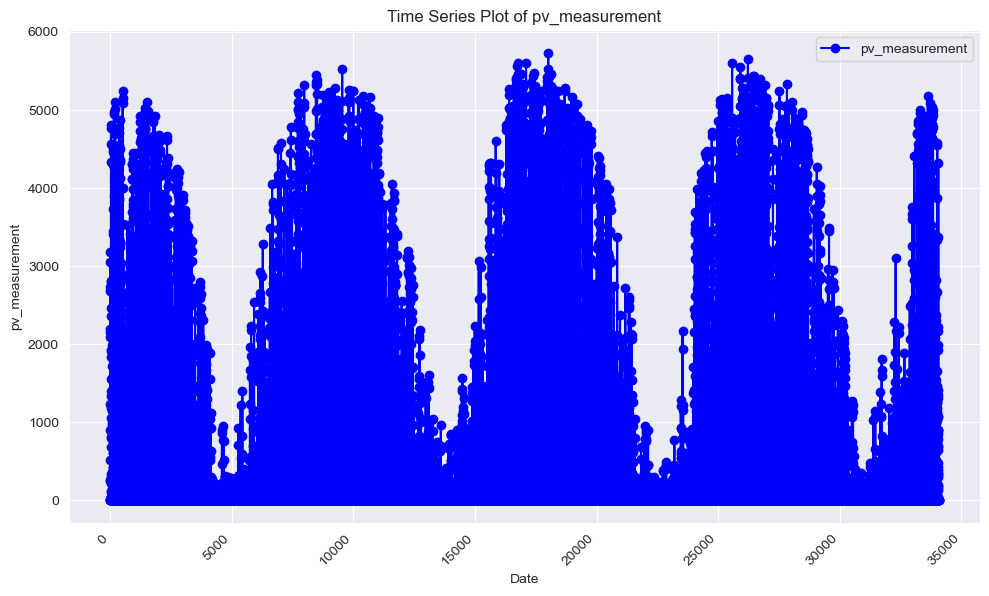

In [67]:
# Extract the column you want to plot
column_to_plot = 'pv_measurement'

# Plot the selected column
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the column data against the datetime index
plt.plot(df.index, df[column_to_plot], marker='o', linestyle='-', color='b', label=column_to_plot)

# Add labels and a title
plt.xlabel('Date')
plt.ylabel(column_to_plot)
plt.title(f'Time Series Plot of {column_to_plot}')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# Define a function to filter rows where date_forecast is not a whole hour
def filter_whole_hour_rows(df, date_forecast_col='date_forecast'):
    # Parse date_forecast column to datetime
    df[date_forecast_col] = pd.to_datetime(df[date_forecast_col])
    # Filter rows where date_forecast is a whole hour
    df_filtered = df[df[date_forecast_col].dt.minute == 0]
    return df_filtered

# Apply the filter to the datasets
X_test_estimated = filter_whole_hour_rows(X_test_estimated)
X_train_estimated = filter_whole_hour_rows(X_train_estimated)
X_train_observed = filter_whole_hour_rows(X_train_observed)

In [ ]:
X_train_observed.isnull().sum()

In [ ]:
X_train_estimated.isnull().sum()

In [ ]:
X_test_estimated.isnull().sum()

In [ ]:
train_targets.isnull().sum()

In [ ]:
def fill_missing_values(df):
    # Fill missing values in 'snow_density:kgm3' with 0
    df['snow_density:kgm3'].fillna(0, inplace=True)

    # Use forward-fill to fill missing values in 'ceiling_height_agl:m' and 'cloud_base_agl:m'
    df['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
    df['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

    # Use backward-fill for any remaining missing values in 'ceiling_height_agl:m' and 'cloud_base_agl:m'
    df['ceiling_height_agl:m'].fillna(method='bfill', inplace=True)
    df['cloud_base_agl:m'].fillna(method='bfill', inplace=True)


# Apply the fill_missing_values function to the datasets
fill_missing_values(X_test_estimated)
fill_missing_values(X_train_estimated)
fill_missing_values(X_train_observed)

In [ ]:
# Merge the observed features and target variables based on common 'date_forecast' and 'time'
X_train_observed['date_forecast'] = pd.to_datetime(X_train_observed['date_forecast'])
X_train_estimated['date_forecast'] = pd.to_datetime(X_train_estimated['date_forecast'])
train_targets['time'] = pd.to_datetime(train_targets['time'])

X_train_observed_merged = pd.merge(X_train_observed, train_targets, left_on='date_forecast', right_on='time', how='inner')
X_train_estimated_merged = pd.merge(X_train_estimated, train_targets, left_on='date_forecast', right_on='time', how='inner')

In [ ]:
def date_features(df):
    df['time'] = df.index
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.dayofyear
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['quarter'] = pd.to_datetime(df['time']).dt.quarter
    return df

date_features(X_train_observed_merged)

In [ ]:
# Create function for rolling stats

In [ ]:
# Create function to merge discrepancy values

In [ ]:
# Create function to add interaction pairs

In [ ]:
# Normalize data

In [ ]:
# Drop non-numeric columns from the merged dataset
merged_train_data_numeric = X_train_observed_merged.select_dtypes(include=['number'])

# Calculate the new correlation matrix
correlation_matrix = merged_train_data_numeric.corr()

# Get the correlation of all features with the target variable 'pv_measurement'
target_correlation = correlation_matrix['pv_measurement'].sort_values(ascending=False)

# Display the top 10 positively correlated and top 10 negatively correlated features with the target variable
top_pos_corr = target_correlation.head(11)[1:]  # Exclude the target variable itself
top_neg_corr = target_correlation.tail(10)

# Plot the top positively correlated features
plt.figure(figsize=(12, 6))
sns.barplot(x=top_pos_corr.index, y=top_pos_corr.values, palette='viridis')
plt.title('Top 10 Positively Correlated Features with Solar Power Production')
plt.xticks(rotation=45)
plt.ylabel('Correlation Coefficient')
plt.show()

# Plot the top negatively correlated features
plt.figure(figsize=(12, 6))
sns.barplot(x=top_neg_corr.index, y=top_neg_corr.values, palette='viridis')
plt.title('Top 10 Negatively Correlated Features with Solar Power Production')
plt.xticks(rotation=45)
plt.ylabel('Correlation Coefficient')
plt.show()

In [ ]:
# Drop non-feature and non-target columns from the merged data
feature_columns = X_train_observed_merged.drop(columns=['time', 'date_forecast', 'pv_measurement'])

# Perform F-test for feature selection
f_values, p_values = f_regression(feature_columns, X_train_observed_merged['pv_measurement'])

# Create a DataFrame to hold the F-values and p-values
f_test_results = pd.DataFrame({'Feature': feature_columns.columns, 'F_value': f_values, 'p_value': p_values})

# Sort the DataFrame based on F-values in descending order
f_test_results = f_test_results.sort_values(by='F_value', ascending=False)

# Display the results
f_test_results.head(15)

In [ ]:
# Initialize XGBoost model with reduced complexity for faster execution
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)

# Drop non-numeric columns from the merged dataset
merged_train_data_numeric = X_train_observed_merged.select_dtypes(include=['number'])

# Separate features and target
X_merged = merged_train_data_numeric.drop(columns=['pv_measurement'])
y_merged = merged_train_data_numeric['pv_measurement']

# Fit the model on the merged dataset
xgb_model.fit(X_merged, y_merged)

# Get feature importances from the model
feature_importances_xgb_merged = xgb_model.feature_importances_

# Create a dictionary to hold feature names and their importance scores
top_features_xgb_merged = {X_merged.columns[i]: feature_importances_xgb_merged[i] for i in range(len(X_merged.columns))}

# Sort the features based on their importance scores and select the top 20
top_features_xgb_merged = {k: v for k, v in sorted(top_features_xgb_merged.items(), key=lambda item: item[1], reverse=True)[:15]}

# Return the top 20 features according to XGBoost on the merged dataset
top_features_xgb_merged

In [ ]:
# Initialize XGBoost Regressor with reduced complexity for faster execution
xgb_estimator = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)

# Initialize RFE with the XGBoost estimator and number of features to select
xgb_selector = RFE(xgb_estimator, n_features_to_select=15, step=1)

# Fit RFE
xgb_selector = xgb_selector.fit(X_merged, y_merged)

# Get the top features based on RFE with XGBoost
top_features_rfe_xgb = {X_merged.columns[i]: xgb_selector.ranking_[i] for i in range(len(X_merged.columns)) if xgb_selector.support_[i]}

top_features_rfe_xgb

In [ ]:
# Separate features and target variable for both training and validation sets
X_train = X_train_observed_merged.drop(['time', 'pv_measurement', 'date_forecast'], axis=1)
y_train = X_train_observed_merged['pv_measurement']

mutual_info = mutual_info_regression(X_train, y_train)
mutual_info_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual_Info': mutual_info})
mutual_info_df.head(15)

In [ ]:
# Generate a list of numeric feature names from the observed or estimated DataFrame
numeric_features = X_train_observed.select_dtypes(include=['number']).columns.tolist()

discrepancy_values = {}
for feature in numeric_features:
    observed_values = X_train_observed[feature]
    estimated_values = X_train_estimated[feature]

    # Calculate mean absolute difference for this feature
    mean_abs_diff = np.mean(np.abs(observed_values - estimated_values))
    discrepancy_values[feature] = mean_abs_diff

# Sort the features by discrepancy
sorted_discrepancy = {k: v for k, v in sorted(discrepancy_values.items(), key=lambda item: item[1], reverse=True)}

sorted_discrepancy

# The most common features across all analysis!

'clear_sky_rad:W'
'diffuse_rad:W'
'direct_rad:W'
'fresh_snow_24h:cm'
'precip_5min:mm'
'pressure_100m:hPa'
'rain_water:kgm2'
'sun_azimuth:d'
'wind_speed_u_10m:ms'
'hour'
'day'
'month'